In [7]:
import os
import sys
import math
import tqdm
import wandb
import torch
import logging

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl

from torchmetrics import MeanAbsoluteError
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

In [8]:
wandb.login()

True

# FCNN

In [9]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y,w):
        criterion = torch.sqrt(torch.mean(w*(x - y)**2)/torch.sum(w))
        return criterion

In [10]:
#params
project_name = "MSU_interpol"

logger_path = './wandb_local_logs'
data_path = '../data/clasdb_pi_plus_n.txt'

hyperparams_dict = {
    'scale_data': False,
    'augment': True,
    'augment_factor': 25,
    'test_size': 0.1,
    'batch_size': 256,
    'net_architecture': [5,60,80,100,120,140,240,340,440,640,2000,1040,640,340,240,140,100,80,60,20,1],
    'activation_function': nn.ReLU(),
    'loss_func': RMSELoss(),
    'optim_func': torch.optim.Adam,
    'max_epochs': 2000,
    'es_min_delta': 0.00001,
    'es_patience': 20,
    'lr': 0.001,
    'lr_factor':0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}

In [11]:
wandb_logger = WandbLogger(project=project_name,
                           save_dir=logger_path)
exp_name = wandb_logger.experiment.name

logger_full_path = os.path.join(logger_path, project_name, exp_name)

os.makedirs(logger_full_path, exist_ok=True)
logging.basicConfig(encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                              logging.StreamHandler(sys.stdout)],
                    force=True)

In [25]:
df = pd.read_csv(data_path, delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df.loc[8314:65671, 'Ebeam'] = 5.754 # peculiarity of this dataset.
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['weight'] = df['error'].apply(lambda x: x and 1 / x or 100) # x and 1 / x or 100  is just a reversed error but with validation 1/0 error in this case it will return 100
df = df.drop('id', axis=1)
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]

<Axes: >

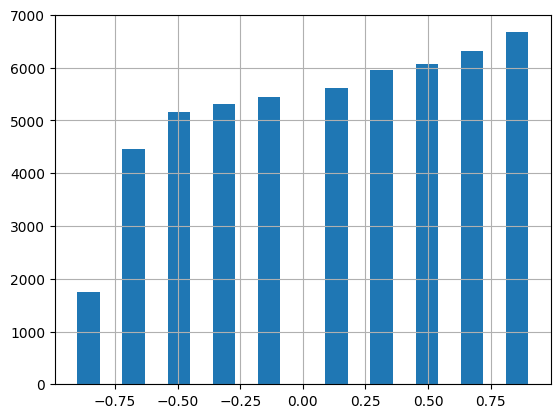

In [40]:
df[df.Ebeam == 5.754].cos_theta.hist(bins = 20)

In [12]:
class InterpolDataSet(Dataset):
    def __init__(self, features, labels, weights):
        self.features = features
        self.labels = labels
        self.weights = weights
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        weights = self.weights[index]
        return feature, label, weights

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None

    def augment(self, new_augm):
        augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam/30),
                           'W': np.random.normal(loc=new_augm.W, scale=new_augm.W/30),
                           'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2/30),
                           'cos_theta': np.clip(np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta/30)), -1, 1),
                           'phi': np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi/30), 0, 2*np.pi),
                           'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error/3),
                           'error': new_augm.error,
                           'weight': new_augm.weight,
                          })
        return augm
    
    def setup(self, stage):
        # data reading and preprocessing
        df = pd.read_csv(data_path, delimiter='\t', header=None)
        df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        df.loc[8314:65671, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        df['phi'] = df.phi.apply(lambda x: math.radians(x))
        df['weight'] = df['error'].apply(lambda x: x and 1 / x or 100) # x and 1 / x or 100  is just a reversed error but with validation 1/0 error in this case it will return 100
        df = df.drop('id', axis=1)
        df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]

        # TODO: critical
        # Ebeam = [5.754]
        # Q2 = [1.72, 2.05, 2.44, 2.91, 3.48, 4.155]
        # df = df[(df.Q2.isin(Q2))&(df.Ebeam.isin(Ebeam))]

        # Ebeam = [5.499]
        # W = [1.830, 1.890, 1.780, 1.950, 2.010, 1.620, 1.660, 1.700, 1.740]
        # df = df[df.Ebeam.isin(Ebeam)&(df.W.isin(W))]

        Ebeam = [1.515]
        df = df[df.Ebeam.isin(Ebeam)]

        #train test split
        feature_columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']
        feature_columns_with_weights = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'weight']

        feature_data = df[feature_columns_with_weights]
        label_data = df['dsigma_dOmega']
        
        if self.hyperparams.get('scale_data'):
            scaler_feature = StandardScaler()
            scaler_target = StandardScaler()
            feature_data = scaler_feature.fit_transform(feature_data)
            label_data = scaler_target.fit_transform(label_data.values.reshape(-1,1))
        else:
            pass

        if self.hyperparams.get('augment'):
            aug_series_list = []
            for i in tqdm.tqdm(df.itertuples()):
                for _ in range(self.hyperparams.get('augment_factor')):
                    aug_series_list.append(self.augment(i))

            aug_df = pd.DataFrame(aug_series_list)
            df = pd.concat([df, aug_df])
        else:
            pass

        self.df = df
        
        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get('test_size'),
                                                                                                  random_state=1438)
        
        
        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data[feature_columns].values, dtype=torch.float32),
                                             torch.tensor(train_label_data.values, dtype=torch.float32),
                                             torch.tensor(train_feature_data['weight'].values, dtype=torch.float32))
        
        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data[feature_columns].values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32),
                                           torch.tensor(val_feature_data['weight'].values, dtype=torch.float32))
    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=0)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=0)

class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()

class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.loss_func = self.hyperparams.get('loss_func')

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y, w = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.train_loss = loss.forward(y_hat.reshape(-1), y, w)
        self.train_mae = self.mae(y_hat.reshape(-1), y)

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y, w = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.val_loss = loss.forward(y_hat.reshape(-1), y, w)
        self.val_mae = self.mae(y_hat.reshape(-1), y)

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        print_callback = PrintCallbacks()

        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                     mode = 'min',
                                     factor = self.hyperparams.get('lr_factor'),
                                     patience = self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose= True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }


In [13]:
data_module = InterpolDataModule(hyperparams=hyperparams_dict)
model = InterpolRegressor(hyperparams=hyperparams_dict)
# model = InterpolRegressor.load_from_checkpoint(f'./wandb_local_logs/MSU_interpol/blooming-plasma-40/checkpoints/exp_name=0val_loss=6.43574-epoch=14.ckpt', hyperparams=hyperparams_dict)

trainer = pl.Trainer(max_epochs=hyperparams_dict.get('max_epochs'),
                     accelerator='cpu',
                     logger=wandb_logger,
                     enable_progress_bar=False)
trainer.fit(model, data_module)

/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
8314i

2024-04-03 15:33:24,359 : INFO : epoch: 0; val_loss: 6.7888078689575195
2024-04-03 15:33:24,370 : INFO : Training is starting


/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/andrey.golda/Library/Caches/pypoetry/virtualenvs/msu-interpol--lw2ADYE-py3.11/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


2024-04-03 15:33:32,669 : INFO : epoch: 0; val_loss: 4.776926040649414
2024-04-03 15:33:32,674 : INFO : epoch: 0; train_loss: 5.608072757720947


Metric val_loss improved. New best score: 4.777


2024-04-03 15:33:32,948 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=4.77693-epoch=00.ckpt
2024-04-03 15:33:40,606 : INFO : epoch: 1; val_loss: 4.123610973358154
2024-04-03 15:33:40,611 : INFO : epoch: 1; train_loss: 4.333993911743164


Metric val_loss improved by 0.653 >= min_delta = 1e-05. New best score: 4.124


2024-04-03 15:33:40,741 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=4.12361-epoch=01.ckpt
2024-04-03 15:33:48,180 : INFO : epoch: 2; val_loss: 4.275135040283203
2024-04-03 15:33:48,184 : INFO : epoch: 2; train_loss: 4.032928943634033
2024-04-03 15:33:48,305 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=4.27514-epoch=02.ckpt
2024-04-03 15:33:55,401 : INFO : epoch: 3; val_loss: 3.8959712982177734
2024-04-03 15:33:55,405 : INFO : epoch: 3; train_loss: 4.0195722579956055


Metric val_loss improved by 0.228 >= min_delta = 1e-05. New best score: 3.896


2024-04-03 15:33:55,517 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=3.89597-epoch=03.ckpt
2024-04-03 15:34:02,330 : INFO : epoch: 4; val_loss: 4.947875022888184
2024-04-03 15:34:02,334 : INFO : epoch: 4; train_loss: 3.727104663848877
2024-04-03 15:34:09,073 : INFO : epoch: 5; val_loss: 3.5977253913879395
2024-04-03 15:34:09,077 : INFO : epoch: 5; train_loss: 3.8076066970825195


Metric val_loss improved by 0.298 >= min_delta = 1e-05. New best score: 3.598


2024-04-03 15:34:09,195 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=3.59773-epoch=05.ckpt
2024-04-03 15:34:15,783 : INFO : epoch: 6; val_loss: 4.230450630187988
2024-04-03 15:34:15,787 : INFO : epoch: 6; train_loss: 3.4066567420959473
2024-04-03 15:34:22,375 : INFO : epoch: 7; val_loss: 3.463385820388794
2024-04-03 15:34:22,379 : INFO : epoch: 7; train_loss: 3.3782200813293457


Metric val_loss improved by 0.134 >= min_delta = 1e-05. New best score: 3.463


2024-04-03 15:34:22,491 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=3.46339-epoch=07.ckpt
2024-04-03 15:34:29,079 : INFO : epoch: 8; val_loss: 3.3067984580993652
2024-04-03 15:34:29,083 : INFO : epoch: 8; train_loss: 3.280388832092285


Metric val_loss improved by 0.157 >= min_delta = 1e-05. New best score: 3.307


2024-04-03 15:34:29,197 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=3.30680-epoch=08.ckpt
2024-04-03 15:34:35,672 : INFO : epoch: 9; val_loss: 3.6408474445343018
2024-04-03 15:34:35,676 : INFO : epoch: 9; train_loss: 3.243169069290161
2024-04-03 15:34:42,207 : INFO : epoch: 10; val_loss: 2.724614381790161
2024-04-03 15:34:42,211 : INFO : epoch: 10; train_loss: 3.020993947982788


Metric val_loss improved by 0.582 >= min_delta = 1e-05. New best score: 2.725


2024-04-03 15:34:42,330 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=2.72461-epoch=10.ckpt
2024-04-03 15:34:48,877 : INFO : epoch: 11; val_loss: 4.672973155975342
2024-04-03 15:34:48,881 : INFO : epoch: 11; train_loss: 2.8118276596069336
2024-04-03 15:34:55,446 : INFO : epoch: 12; val_loss: 3.066683292388916
2024-04-03 15:34:55,450 : INFO : epoch: 12; train_loss: 2.9950637817382812
2024-04-03 15:34:55,555 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=3.06668-epoch=12.ckpt
2024-04-03 15:35:02,054 : INFO : epoch: 13; val_loss: 2.1623129844665527
2024-04-03 15:35:02,057 : INFO : epoch: 13; train_loss: 2.2053487300872803


Metric val_loss improved by 0.562 >= min_delta = 1e-05. New best score: 2.162


2024-04-03 15:35:02,166 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=2.16231-epoch=13.ckpt
2024-04-03 15:35:08,629 : INFO : epoch: 14; val_loss: 1.786646842956543
2024-04-03 15:35:08,632 : INFO : epoch: 14; train_loss: 1.9283736944198608


Metric val_loss improved by 0.376 >= min_delta = 1e-05. New best score: 1.787


2024-04-03 15:35:08,741 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.78665-epoch=14.ckpt
2024-04-03 15:35:15,225 : INFO : epoch: 15; val_loss: 2.207446336746216
2024-04-03 15:35:15,231 : INFO : epoch: 15; train_loss: 1.9505608081817627
2024-04-03 15:35:15,344 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=2.20745-epoch=15.ckpt
2024-04-03 15:35:22,337 : INFO : epoch: 16; val_loss: 2.6135001182556152
2024-04-03 15:35:22,341 : INFO : epoch: 16; train_loss: 1.7752583026885986
2024-04-03 15:35:29,117 : INFO : epoch: 17; val_loss: 1.8457951545715332
2024-04-03 15:35:29,120 : INFO : epoch: 17; train_loss: 1.9731849431991577
2024-04-03 15:35:29,230 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energ

Metric val_loss improved by 0.159 >= min_delta = 1e-05. New best score: 1.627


2024-04-03 15:35:36,157 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.62740-epoch=18.ckpt
2024-04-03 15:35:43,112 : INFO : epoch: 19; val_loss: 2.01495623588562
2024-04-03 15:35:43,116 : INFO : epoch: 19; train_loss: 1.504831314086914
2024-04-03 15:35:49,989 : INFO : epoch: 20; val_loss: 1.5419859886169434
2024-04-03 15:35:49,993 : INFO : epoch: 20; train_loss: 1.4692723751068115


Metric val_loss improved by 0.085 >= min_delta = 1e-05. New best score: 1.542


2024-04-03 15:35:50,109 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.54199-epoch=20.ckpt
2024-04-03 15:35:57,268 : INFO : epoch: 21; val_loss: 1.3764909505844116
2024-04-03 15:35:57,273 : INFO : epoch: 21; train_loss: 1.3927010297775269


Metric val_loss improved by 0.165 >= min_delta = 1e-05. New best score: 1.376


2024-04-03 15:35:57,393 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.37649-epoch=21.ckpt
2024-04-03 15:36:04,588 : INFO : epoch: 22; val_loss: 1.536955714225769
2024-04-03 15:36:04,592 : INFO : epoch: 22; train_loss: 1.3115906715393066
2024-04-03 15:36:04,703 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.53696-epoch=22.ckpt
2024-04-03 15:36:11,888 : INFO : epoch: 23; val_loss: 1.4120471477508545
2024-04-03 15:36:11,892 : INFO : epoch: 23; train_loss: 1.455755591392517
2024-04-03 15:36:12,006 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.41205-epoch=23.ckpt
2024-04-03 15:36:19,527 : INFO : epoch: 24; val_loss: 1.283977746963501
2024-04-03

Metric val_loss improved by 0.093 >= min_delta = 1e-05. New best score: 1.284


2024-04-03 15:36:19,649 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.28398-epoch=24.ckpt
2024-04-03 15:36:27,023 : INFO : epoch: 25; val_loss: 1.54290771484375
2024-04-03 15:36:27,027 : INFO : epoch: 25; train_loss: 1.4799562692642212
2024-04-03 15:36:34,069 : INFO : epoch: 26; val_loss: 1.461167573928833
2024-04-03 15:36:34,073 : INFO : epoch: 26; train_loss: 1.3425127267837524
2024-04-03 15:36:40,769 : INFO : epoch: 27; val_loss: 1.4504430294036865
2024-04-03 15:36:40,772 : INFO : epoch: 27; train_loss: 1.2543482780456543
2024-04-03 15:36:47,493 : INFO : epoch: 28; val_loss: 1.5193662643432617
2024-04-03 15:36:47,497 : INFO : epoch: 28; train_loss: 1.249321699142456
2024-04-03 15:36:54,474 : INFO : epoch: 29; val_loss: 1.4523413181304932
2024-04-03 15:36:54,477 : INFO : epoch: 29; train_loss: 1.2310656309127808
2024-04-03 15:37:01,230 : INFO : epoch: 30; val_loss: 1.

Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 1.279


2024-04-03 15:37:01,344 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.27854-epoch=30.ckpt
2024-04-03 15:37:08,134 : INFO : epoch: 31; val_loss: 1.3136889934539795
2024-04-03 15:37:08,138 : INFO : epoch: 31; train_loss: 1.2399065494537354
2024-04-03 15:37:08,250 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.31369-epoch=31.ckpt
2024-04-03 15:37:15,033 : INFO : epoch: 32; val_loss: 1.2890441417694092
2024-04-03 15:37:15,056 : INFO : epoch: 32; train_loss: 1.2293789386749268
2024-04-03 15:37:15,164 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.28904-epoch=32.ckpt
2024-04-03 15:37:22,051 : INFO : epoch: 33; val_loss: 1.2817848920822144
2024-04

Metric val_loss improved by 0.033 >= min_delta = 1e-05. New best score: 1.245


2024-04-03 15:37:44,615 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.24536-epoch=36.ckpt
2024-04-03 15:37:51,597 : INFO : epoch: 37; val_loss: 1.2535459995269775
2024-04-03 15:37:51,601 : INFO : epoch: 37; train_loss: 1.1549264192581177
2024-04-03 15:37:51,710 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.25355-epoch=37.ckpt
2024-04-03 15:37:59,062 : INFO : epoch: 38; val_loss: 1.2579187154769897
2024-04-03 15:37:59,066 : INFO : epoch: 38; train_loss: 1.1486009359359741
2024-04-03 15:37:59,180 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.25792-epoch=38.ckpt
2024-04-03 15:38:06,328 : INFO : epoch: 39; val_loss: 1.2487019300460815
2024-04

Metric val_loss improved by 0.027 >= min_delta = 1e-05. New best score: 1.218


2024-04-03 15:38:13,750 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.21795-epoch=40.ckpt
2024-04-03 15:38:21,071 : INFO : epoch: 41; val_loss: 1.1899268627166748
2024-04-03 15:38:21,075 : INFO : epoch: 41; train_loss: 1.1414203643798828


Metric val_loss improved by 0.028 >= min_delta = 1e-05. New best score: 1.190


2024-04-03 15:38:21,198 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.18993-epoch=41.ckpt
2024-04-03 15:38:28,727 : INFO : epoch: 42; val_loss: 1.1879096031188965
2024-04-03 15:38:28,730 : INFO : epoch: 42; train_loss: 1.1191200017929077


Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 1.188


2024-04-03 15:38:28,845 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.18791-epoch=42.ckpt
2024-04-03 15:38:36,042 : INFO : epoch: 43; val_loss: 1.1908692121505737
2024-04-03 15:38:36,046 : INFO : epoch: 43; train_loss: 1.1075674295425415
2024-04-03 15:38:36,176 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.19087-epoch=43.ckpt
2024-04-03 15:38:43,340 : INFO : epoch: 44; val_loss: 1.202139139175415
2024-04-03 15:38:43,344 : INFO : epoch: 44; train_loss: 1.097122311592102
2024-04-03 15:38:50,452 : INFO : epoch: 45; val_loss: 1.2176635265350342
2024-04-03 15:38:50,456 : INFO : epoch: 45; train_loss: 1.0868216753005981
2024-04-03 15:38:57,503 : INFO : epoch: 46; val_loss: 1.1387667655944824
2024-04-03 15:38:57,507 : INFO : epoch: 46; train_loss: 1.01499009132

Metric val_loss improved by 0.049 >= min_delta = 1e-05. New best score: 1.139


2024-04-03 15:38:57,624 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.13877-epoch=46.ckpt
2024-04-03 15:39:04,838 : INFO : epoch: 47; val_loss: 1.111556053161621
2024-04-03 15:39:04,843 : INFO : epoch: 47; train_loss: 0.9940626621246338


Metric val_loss improved by 0.027 >= min_delta = 1e-05. New best score: 1.112


2024-04-03 15:39:04,955 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.11156-epoch=47.ckpt
2024-04-03 15:39:12,193 : INFO : epoch: 48; val_loss: 1.1113389730453491
2024-04-03 15:39:12,196 : INFO : epoch: 48; train_loss: 0.9835677742958069


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.111


2024-04-03 15:39:12,314 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.11134-epoch=48.ckpt
2024-04-03 15:39:19,552 : INFO : epoch: 49; val_loss: 1.1115399599075317
2024-04-03 15:39:19,557 : INFO : epoch: 49; train_loss: 0.9801690578460693
2024-04-03 15:39:19,679 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.11154-epoch=49.ckpt
2024-04-03 15:39:27,068 : INFO : epoch: 50; val_loss: 1.1133157014846802
2024-04-03 15:39:27,072 : INFO : epoch: 50; train_loss: 0.9771605134010315
2024-04-03 15:39:34,284 : INFO : epoch: 51; val_loss: 1.1129515171051025
2024-04-03 15:39:34,288 : INFO : epoch: 51; train_loss: 0.9752339124679565
2024-04-03 15:39:41,408 : INFO : epoch: 52; val_loss: 1.1135897636413574
2024-04-03 15:39:41,412 : INFO : epoch: 52; train_loss: 0.974174678

Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 1.106


2024-04-03 15:39:55,911 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.10633-epoch=54.ckpt
2024-04-03 15:40:03,068 : INFO : epoch: 55; val_loss: 1.1006927490234375
2024-04-03 15:40:03,073 : INFO : epoch: 55; train_loss: 0.9652510285377502


Metric val_loss improved by 0.006 >= min_delta = 1e-05. New best score: 1.101


2024-04-03 15:40:03,189 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.10069-epoch=55.ckpt
2024-04-03 15:40:10,303 : INFO : epoch: 56; val_loss: 1.0915741920471191
2024-04-03 15:40:10,309 : INFO : epoch: 56; train_loss: 0.9607158899307251


Metric val_loss improved by 0.009 >= min_delta = 1e-05. New best score: 1.092


2024-04-03 15:40:10,424 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.09157-epoch=56.ckpt
2024-04-03 15:40:17,548 : INFO : epoch: 57; val_loss: 1.0845108032226562
2024-04-03 15:40:17,553 : INFO : epoch: 57; train_loss: 0.9547626972198486


Metric val_loss improved by 0.007 >= min_delta = 1e-05. New best score: 1.085


2024-04-03 15:40:17,672 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.08451-epoch=57.ckpt
2024-04-03 15:40:25,292 : INFO : epoch: 58; val_loss: 1.0803145170211792
2024-04-03 15:40:25,296 : INFO : epoch: 58; train_loss: 0.9492148756980896


Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 1.080


2024-04-03 15:40:25,417 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.08031-epoch=58.ckpt
2024-04-03 15:40:32,966 : INFO : epoch: 59; val_loss: 1.0775723457336426
2024-04-03 15:40:32,970 : INFO : epoch: 59; train_loss: 0.9445518255233765


Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 1.078


2024-04-03 15:40:33,091 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.07757-epoch=59.ckpt
2024-04-03 15:40:40,618 : INFO : epoch: 60; val_loss: 1.0748682022094727
2024-04-03 15:40:40,621 : INFO : epoch: 60; train_loss: 0.940013587474823


Metric val_loss improved by 0.003 >= min_delta = 1e-05. New best score: 1.075


2024-04-03 15:40:40,745 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.07487-epoch=60.ckpt
2024-04-03 15:40:48,755 : INFO : epoch: 61; val_loss: 1.0727479457855225
2024-04-03 15:40:48,760 : INFO : epoch: 61; train_loss: 0.9355008602142334


Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 1.073


2024-04-03 15:40:48,894 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.07275-epoch=61.ckpt
2024-04-03 15:40:56,887 : INFO : epoch: 62; val_loss: 1.0717235803604126
2024-04-03 15:40:56,892 : INFO : epoch: 62; train_loss: 0.9318822026252747


Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.072


2024-04-03 15:40:57,018 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.07172-epoch=62.ckpt
2024-04-03 15:41:05,132 : INFO : epoch: 63; val_loss: 1.071058988571167
2024-04-03 15:41:05,137 : INFO : epoch: 63; train_loss: 0.928899884223938


Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.071


2024-04-03 15:41:05,265 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.07106-epoch=63.ckpt
2024-04-03 15:41:13,898 : INFO : epoch: 64; val_loss: 1.1025652885437012
2024-04-03 15:41:13,903 : INFO : epoch: 64; train_loss: 0.9211076498031616
2024-04-03 15:41:22,488 : INFO : epoch: 65; val_loss: 1.0960274934768677
2024-04-03 15:41:22,493 : INFO : epoch: 65; train_loss: 0.9345124363899231
2024-04-03 15:41:31,148 : INFO : epoch: 66; val_loss: 1.0843125581741333
2024-04-03 15:41:31,153 : INFO : epoch: 66; train_loss: 0.9374485015869141
2024-04-03 15:41:40,077 : INFO : epoch: 67; val_loss: 1.0805754661560059
2024-04-03 15:41:40,082 : INFO : epoch: 67; train_loss: 0.9308350086212158
2024-04-03 15:41:49,197 : INFO : epoch: 68; val_loss: 1.0799663066864014
2024-04-03 15:41:49,202 : INFO : epoch: 68; train_loss: 0.925240695476532
2024-04-03 15:41:58,280 : INFO : epoch: 69; val_loss:

Metric val_loss improved by 0.024 >= min_delta = 1e-05. New best score: 1.047


2024-04-03 15:43:40,467 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.04678-epoch=81.ckpt
2024-04-03 15:43:48,644 : INFO : epoch: 82; val_loss: 1.05253267288208
2024-04-03 15:43:48,649 : INFO : epoch: 82; train_loss: 0.9049178957939148
2024-04-03 15:43:48,777 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.05253-epoch=82.ckpt
2024-04-03 15:43:57,042 : INFO : epoch: 83; val_loss: 1.0514154434204102
2024-04-03 15:43:57,046 : INFO : epoch: 83; train_loss: 0.9012032747268677
2024-04-03 15:43:57,172 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.05142-epoch=83.ckpt
2024-04-03 15:44:05,528 : INFO : epoch: 84; val_loss: 1.0507330894470215
2024-04-0

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.047


2024-04-03 15:44:59,686 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.04655-epoch=91.ckpt
2024-04-03 15:45:07,297 : INFO : epoch: 92; val_loss: 1.04559326171875
2024-04-03 15:45:07,301 : INFO : epoch: 92; train_loss: 0.8883168697357178


Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.046


2024-04-03 15:45:07,426 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.04559-epoch=92.ckpt
2024-04-03 15:45:15,082 : INFO : epoch: 93; val_loss: 1.045716404914856
2024-04-03 15:45:15,086 : INFO : epoch: 93; train_loss: 0.8874667286872864
2024-04-03 15:45:15,201 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.04572-epoch=93.ckpt
2024-04-03 15:45:22,680 : INFO : epoch: 94; val_loss: 1.0453225374221802
2024-04-03 15:45:22,684 : INFO : epoch: 94; train_loss: 0.8865472078323364


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.045


2024-04-03 15:45:22,802 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.04532-epoch=94.ckpt
2024-04-03 15:45:30,435 : INFO : epoch: 95; val_loss: 1.0448744297027588
2024-04-03 15:45:30,440 : INFO : epoch: 95; train_loss: 0.8860893845558167


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.045


2024-04-03 15:45:30,562 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.04487-epoch=95.ckpt
2024-04-03 15:45:38,057 : INFO : epoch: 96; val_loss: 1.0438973903656006
2024-04-03 15:45:38,061 : INFO : epoch: 96; train_loss: 0.8852596282958984


Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.044


2024-04-03 15:45:38,180 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.04390-epoch=96.ckpt
2024-04-03 15:45:45,724 : INFO : epoch: 97; val_loss: 1.0432974100112915
2024-04-03 15:45:45,728 : INFO : epoch: 97; train_loss: 0.8845353722572327


Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.043


2024-04-03 15:45:45,846 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.04330-epoch=97.ckpt
2024-04-03 15:45:53,296 : INFO : epoch: 98; val_loss: 1.0409505367279053
2024-04-03 15:45:53,300 : INFO : epoch: 98; train_loss: 0.8796471953392029


Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 1.041


2024-04-03 15:45:53,422 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.04095-epoch=98.ckpt
2024-04-03 15:46:00,867 : INFO : epoch: 99; val_loss: 1.039649486541748
2024-04-03 15:46:00,871 : INFO : epoch: 99; train_loss: 0.8797096014022827


Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.040


2024-04-03 15:46:00,990 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03965-epoch=99.ckpt
2024-04-03 15:46:08,469 : INFO : epoch: 100; val_loss: 1.0390468835830688
2024-04-03 15:46:08,473 : INFO : epoch: 100; train_loss: 0.8766292929649353


Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.039


2024-04-03 15:46:08,595 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03905-epoch=100.ckpt
2024-04-03 15:46:16,055 : INFO : epoch: 101; val_loss: 1.0383232831954956
2024-04-03 15:46:16,059 : INFO : epoch: 101; train_loss: 0.8756008148193359


Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.038


2024-04-03 15:46:16,180 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03832-epoch=101.ckpt
2024-04-03 15:46:23,817 : INFO : epoch: 102; val_loss: 1.0378432273864746
2024-04-03 15:46:23,822 : INFO : epoch: 102; train_loss: 0.875011682510376


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.038


2024-04-03 15:46:23,942 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03784-epoch=102.ckpt
2024-04-03 15:46:31,716 : INFO : epoch: 103; val_loss: 1.0372282266616821
2024-04-03 15:46:31,719 : INFO : epoch: 103; train_loss: 0.8744059205055237


Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.037


2024-04-03 15:46:31,841 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03723-epoch=103.ckpt
2024-04-03 15:46:39,427 : INFO : epoch: 104; val_loss: 1.0368846654891968
2024-04-03 15:46:39,431 : INFO : epoch: 104; train_loss: 0.8738025426864624


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.037


2024-04-03 15:46:39,551 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03688-epoch=104.ckpt
2024-04-03 15:46:47,621 : INFO : epoch: 105; val_loss: 1.036303997039795
2024-04-03 15:46:47,626 : INFO : epoch: 105; train_loss: 0.8732644319534302


Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.036


2024-04-03 15:46:47,754 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03630-epoch=105.ckpt
2024-04-03 15:46:55,770 : INFO : epoch: 106; val_loss: 1.0359928607940674
2024-04-03 15:46:55,774 : INFO : epoch: 106; train_loss: 0.8727476596832275


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.036


2024-04-03 15:46:55,901 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03599-epoch=106.ckpt
2024-04-03 15:47:03,928 : INFO : epoch: 107; val_loss: 1.0355782508850098
2024-04-03 15:47:03,932 : INFO : epoch: 107; train_loss: 0.8722526431083679


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.036


2024-04-03 15:47:04,059 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03558-epoch=107.ckpt
2024-04-03 15:47:12,178 : INFO : epoch: 108; val_loss: 1.0351581573486328
2024-04-03 15:47:12,182 : INFO : epoch: 108; train_loss: 0.8717724084854126


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.035


2024-04-03 15:47:12,307 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03516-epoch=108.ckpt
2024-04-03 15:47:20,497 : INFO : epoch: 109; val_loss: 1.0348416566848755
2024-04-03 15:47:20,501 : INFO : epoch: 109; train_loss: 0.8712265491485596


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.035


2024-04-03 15:47:20,627 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03484-epoch=109.ckpt
2024-04-03 15:47:29,092 : INFO : epoch: 110; val_loss: 1.034654974937439
2024-04-03 15:47:29,099 : INFO : epoch: 110; train_loss: 0.8708170652389526


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.035


2024-04-03 15:47:29,235 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03465-epoch=110.ckpt
2024-04-03 15:47:37,770 : INFO : epoch: 111; val_loss: 1.0345155000686646
2024-04-03 15:47:37,775 : INFO : epoch: 111; train_loss: 0.8703587055206299


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.035


2024-04-03 15:47:37,913 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03452-epoch=111.ckpt
2024-04-03 15:47:46,403 : INFO : epoch: 112; val_loss: 1.0341527462005615
2024-04-03 15:47:46,407 : INFO : epoch: 112; train_loss: 0.8698025941848755


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.034


2024-04-03 15:47:46,540 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03415-epoch=112.ckpt
2024-04-03 15:47:55,193 : INFO : epoch: 113; val_loss: 1.0338118076324463
2024-04-03 15:47:55,198 : INFO : epoch: 113; train_loss: 0.869301438331604


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.034


2024-04-03 15:47:55,331 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03381-epoch=113.ckpt
2024-04-03 15:48:03,836 : INFO : epoch: 114; val_loss: 1.0336664915084839
2024-04-03 15:48:03,840 : INFO : epoch: 114; train_loss: 0.8689060211181641


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.034


2024-04-03 15:48:03,971 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03367-epoch=114.ckpt
2024-04-03 15:48:12,460 : INFO : epoch: 115; val_loss: 1.0331158638000488
2024-04-03 15:48:12,465 : INFO : epoch: 115; train_loss: 0.8684577941894531


Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.033


2024-04-03 15:48:12,599 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03312-epoch=115.ckpt
2024-04-03 15:48:21,125 : INFO : epoch: 116; val_loss: 1.0365591049194336
2024-04-03 15:48:21,130 : INFO : epoch: 116; train_loss: 0.8654069900512695
2024-04-03 15:48:29,677 : INFO : epoch: 117; val_loss: 1.036722183227539
2024-04-03 15:48:29,685 : INFO : epoch: 117; train_loss: 0.8635756969451904
2024-04-03 15:48:38,301 : INFO : epoch: 118; val_loss: 1.0358842611312866
2024-04-03 15:48:38,306 : INFO : epoch: 118; train_loss: 0.8623252511024475
2024-04-03 15:48:47,007 : INFO : epoch: 119; val_loss: 1.036281943321228
2024-04-03 15:48:47,011 : INFO : epoch: 119; train_loss: 0.8624288439750671
2024-04-03 15:48:55,515 : INFO : epoch: 120; val_loss: 1.0362647771835327
2024-04-03 15:48:55,520 : INFO : epoch: 120; train_loss: 0.8622169494628906
2024-04-03 15:49:03,973 : INFO : epoch: 121

Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 1.032


2024-04-03 15:50:35,312 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03234-epoch=133.ckpt
2024-04-03 15:50:42,574 : INFO : epoch: 134; val_loss: 1.0328490734100342
2024-04-03 15:50:42,578 : INFO : epoch: 134; train_loss: 0.8546743392944336
2024-04-03 15:50:42,688 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03285-epoch=134.ckpt
2024-04-03 15:50:49,782 : INFO : epoch: 135; val_loss: 1.0329962968826294
2024-04-03 15:50:49,785 : INFO : epoch: 135; train_loss: 0.8545223474502563
2024-04-03 15:50:49,895 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03300-epoch=135.ckpt
2024-04-03 15:50:56,999 : INFO : epoch: 136; val_loss: 1.0328700542449951

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.032


2024-04-03 15:52:19,840 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03229-epoch=148.ckpt
2024-04-03 15:52:26,855 : INFO : epoch: 149; val_loss: 1.032173752784729
2024-04-03 15:52:26,858 : INFO : epoch: 149; train_loss: 0.8533604741096497


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.032


2024-04-03 15:52:26,967 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03217-epoch=149.ckpt
2024-04-03 15:52:33,901 : INFO : epoch: 150; val_loss: 1.0321810245513916
2024-04-03 15:52:33,905 : INFO : epoch: 150; train_loss: 0.8520572185516357
2024-04-03 15:52:34,009 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03218-epoch=150.ckpt
2024-04-03 15:52:40,718 : INFO : epoch: 151; val_loss: 1.031981348991394
2024-04-03 15:52:40,722 : INFO : epoch: 151; train_loss: 0.8520346879959106


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.032


2024-04-03 15:52:40,830 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03198-epoch=151.ckpt
2024-04-03 15:52:47,592 : INFO : epoch: 152; val_loss: 1.0319596529006958
2024-04-03 15:52:47,603 : INFO : epoch: 152; train_loss: 0.851976752281189


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.032


2024-04-03 15:52:47,717 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03196-epoch=152.ckpt
2024-04-03 15:52:54,520 : INFO : epoch: 153; val_loss: 1.0318951606750488
2024-04-03 15:52:54,523 : INFO : epoch: 153; train_loss: 0.8519132137298584


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.032


2024-04-03 15:52:54,631 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03190-epoch=153.ckpt
2024-04-03 15:53:01,393 : INFO : epoch: 154; val_loss: 1.0318527221679688
2024-04-03 15:53:01,396 : INFO : epoch: 154; train_loss: 0.8518550992012024


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.032


2024-04-03 15:53:01,502 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03185-epoch=154.ckpt
2024-04-03 15:53:08,345 : INFO : epoch: 155; val_loss: 1.0318629741668701
2024-04-03 15:53:08,349 : INFO : epoch: 155; train_loss: 0.8517968654632568
2024-04-03 15:53:08,455 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03186-epoch=155.ckpt
2024-04-03 15:53:15,183 : INFO : epoch: 156; val_loss: 1.0318238735198975
2024-04-03 15:53:15,187 : INFO : epoch: 156; train_loss: 0.8517488241195679


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.032


2024-04-03 15:53:15,307 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03182-epoch=156.ckpt
2024-04-03 15:53:22,058 : INFO : epoch: 157; val_loss: 1.0317670106887817
2024-04-03 15:53:22,080 : INFO : epoch: 157; train_loss: 0.8516868352890015


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.032


2024-04-03 15:53:22,189 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03177-epoch=157.ckpt
2024-04-03 15:53:28,934 : INFO : epoch: 158; val_loss: 1.0317682027816772
2024-04-03 15:53:28,938 : INFO : epoch: 158; train_loss: 0.8516355752944946
2024-04-03 15:53:29,042 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03177-epoch=158.ckpt
2024-04-03 15:53:36,016 : INFO : epoch: 159; val_loss: 1.031772255897522
2024-04-03 15:53:36,019 : INFO : epoch: 159; train_loss: 0.8515902757644653
2024-04-03 15:53:36,125 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03177-epoch=159.ckpt
2024-04-03 15:53:42,876 : INFO : epoch: 160; val_loss: 1.0317740440368652


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.032


2024-04-03 15:54:03,382 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03174-epoch=163.ckpt
2024-04-03 15:54:10,111 : INFO : epoch: 164; val_loss: 1.0317310094833374
2024-04-03 15:54:10,114 : INFO : epoch: 164; train_loss: 0.8513396382331848


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.032


2024-04-03 15:54:10,222 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03173-epoch=164.ckpt
2024-04-03 15:54:17,074 : INFO : epoch: 165; val_loss: 1.0317093133926392
2024-04-03 15:54:17,077 : INFO : epoch: 165; train_loss: 0.8512923717498779


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.032


2024-04-03 15:54:17,192 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03171-epoch=165.ckpt
2024-04-03 15:54:24,276 : INFO : epoch: 166; val_loss: 1.0316956043243408
2024-04-03 15:54:24,280 : INFO : epoch: 166; train_loss: 0.8512424826622009


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.032


2024-04-03 15:54:24,402 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03170-epoch=166.ckpt
2024-04-03 15:54:31,645 : INFO : epoch: 167; val_loss: 1.0316907167434692
2024-04-03 15:54:31,649 : INFO : epoch: 167; train_loss: 0.8511952757835388
2024-04-03 15:54:31,760 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.03169-epoch=167.ckpt
2024-04-03 15:54:39,078 : INFO : epoch: 168; val_loss: 1.029700756072998
2024-04-03 15:54:39,082 : INFO : epoch: 168; train_loss: 0.8506876826286316


Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 1.030


2024-04-03 15:54:39,197 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02970-epoch=168.ckpt
2024-04-03 15:54:46,724 : INFO : epoch: 169; val_loss: 1.029538869857788
2024-04-03 15:54:46,728 : INFO : epoch: 169; train_loss: 0.85062575340271


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.030


2024-04-03 15:54:46,845 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02954-epoch=169.ckpt
2024-04-03 15:54:54,379 : INFO : epoch: 170; val_loss: 1.0295815467834473
2024-04-03 15:54:54,384 : INFO : epoch: 170; train_loss: 0.8505834341049194
2024-04-03 15:54:54,503 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02958-epoch=170.ckpt
2024-04-03 15:55:02,212 : INFO : epoch: 171; val_loss: 1.0295825004577637
2024-04-03 15:55:02,216 : INFO : epoch: 171; train_loss: 0.8505582213401794
2024-04-03 15:55:02,334 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02958-epoch=171.ckpt
2024-04-03 15:55:09,841 : INFO : epoch: 172; val_loss: 1.0295511484146118

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.030


2024-04-03 15:55:55,989 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02953-epoch=178.ckpt
2024-04-03 15:56:03,700 : INFO : epoch: 179; val_loss: 1.0295109748840332
2024-04-03 15:56:03,703 : INFO : epoch: 179; train_loss: 0.8503644466400146


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.030


2024-04-03 15:56:03,824 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02951-epoch=179.ckpt
2024-04-03 15:56:11,483 : INFO : epoch: 180; val_loss: 1.0295233726501465
2024-04-03 15:56:11,487 : INFO : epoch: 180; train_loss: 0.8503344058990479
2024-04-03 15:56:11,600 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02952-epoch=180.ckpt
2024-04-03 15:56:19,211 : INFO : epoch: 181; val_loss: 1.029500961303711
2024-04-03 15:56:19,215 : INFO : epoch: 181; train_loss: 0.850311815738678
2024-04-03 15:56:19,349 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02950-epoch=181.ckpt
2024-04-03 15:56:26,961 : INFO : epoch: 182; val_loss: 1.0295103788375854
2

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 15:56:49,574 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02912-epoch=185.ckpt
2024-04-03 15:56:56,713 : INFO : epoch: 186; val_loss: 1.0292158126831055
2024-04-03 15:56:56,717 : INFO : epoch: 186; train_loss: 0.849720299243927
2024-04-03 15:56:56,829 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02922-epoch=186.ckpt
2024-04-03 15:57:04,150 : INFO : epoch: 187; val_loss: 1.029163122177124
2024-04-03 15:57:04,154 : INFO : epoch: 187; train_loss: 0.8497191071510315
2024-04-03 15:57:04,263 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02916-epoch=187.ckpt
2024-04-03 15:57:11,358 : INFO : epoch: 188; val_loss: 1.0291693210601807
2

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 15:58:32,883 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02911-epoch=200.ckpt
2024-04-03 15:58:39,457 : INFO : epoch: 201; val_loss: 1.0291104316711426
2024-04-03 15:58:39,460 : INFO : epoch: 201; train_loss: 0.8495371341705322
2024-04-03 15:58:39,560 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02911-epoch=201.ckpt
2024-04-03 15:58:45,998 : INFO : epoch: 202; val_loss: 1.0290662050247192
2024-04-03 15:58:46,001 : INFO : epoch: 202; train_loss: 0.8493597507476807


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 15:58:46,103 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02907-epoch=202.ckpt
2024-04-03 15:58:52,539 : INFO : epoch: 203; val_loss: 1.0290415287017822
2024-04-03 15:58:52,542 : INFO : epoch: 203; train_loss: 0.8493146300315857


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 15:58:52,646 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02904-epoch=203.ckpt
2024-04-03 15:58:59,357 : INFO : epoch: 204; val_loss: 1.0290452241897583
2024-04-03 15:58:59,360 : INFO : epoch: 204; train_loss: 0.8493103384971619
2024-04-03 15:58:59,460 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02905-epoch=204.ckpt
2024-04-03 15:59:06,027 : INFO : epoch: 205; val_loss: 1.0290359258651733
2024-04-03 15:59:06,031 : INFO : epoch: 205; train_loss: 0.8493033647537231
2024-04-03 15:59:06,138 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02904-epoch=205.ckpt
2024-04-03 15:59:12,568 : INFO : epoch: 206; val_loss: 1.029033899307251


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 15:59:19,192 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02903-epoch=207.ckpt
2024-04-03 15:59:25,917 : INFO : epoch: 208; val_loss: 1.0290203094482422
2024-04-03 15:59:25,921 : INFO : epoch: 208; train_loss: 0.8492825627326965
2024-04-03 15:59:26,025 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02902-epoch=208.ckpt
2024-04-03 15:59:32,751 : INFO : epoch: 209; val_loss: 1.0290168523788452
2024-04-03 15:59:32,754 : INFO : epoch: 209; train_loss: 0.8492753505706787
2024-04-03 15:59:32,861 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02902-epoch=209.ckpt
2024-04-03 15:59:39,787 : INFO : epoch: 210; val_loss: 1.0290138721466064

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 15:59:39,905 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02901-epoch=210.ckpt
2024-04-03 15:59:46,805 : INFO : epoch: 211; val_loss: 1.0290119647979736
2024-04-03 15:59:46,809 : INFO : epoch: 211; train_loss: 0.8492615818977356
2024-04-03 15:59:46,915 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02901-epoch=211.ckpt
2024-04-03 15:59:53,657 : INFO : epoch: 212; val_loss: 1.0290091037750244
2024-04-03 15:59:53,660 : INFO : epoch: 212; train_loss: 0.849254846572876
2024-04-03 15:59:53,777 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02901-epoch=212.ckpt
2024-04-03 16:00:00,642 : INFO : epoch: 213; val_loss: 1.029004454612732
2

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 16:00:07,704 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02900-epoch=214.ckpt
2024-04-03 16:00:14,677 : INFO : epoch: 215; val_loss: 1.0290006399154663
2024-04-03 16:00:14,680 : INFO : epoch: 215; train_loss: 0.8492337465286255
2024-04-03 16:00:14,785 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02900-epoch=215.ckpt
2024-04-03 16:00:21,624 : INFO : epoch: 216; val_loss: 1.0289998054504395
2024-04-03 16:00:21,627 : INFO : epoch: 216; train_loss: 0.8492270708084106
2024-04-03 16:00:21,735 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02900-epoch=216.ckpt
2024-04-03 16:00:28,548 : INFO : epoch: 217; val_loss: 1.0289943218231201

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 16:00:42,630 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02899-epoch=219.ckpt
2024-04-03 16:00:49,396 : INFO : epoch: 220; val_loss: 1.028975248336792
2024-04-03 16:00:49,399 : INFO : epoch: 220; train_loss: 0.8491130471229553


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 16:00:49,506 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02898-epoch=220.ckpt
2024-04-03 16:00:56,193 : INFO : epoch: 221; val_loss: 1.0289579629898071
2024-04-03 16:00:56,197 : INFO : epoch: 221; train_loss: 0.849104642868042


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 16:00:56,311 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02896-epoch=221.ckpt
2024-04-03 16:01:03,100 : INFO : epoch: 222; val_loss: 1.0289562940597534
2024-04-03 16:01:03,103 : INFO : epoch: 222; train_loss: 0.8490985631942749
2024-04-03 16:01:03,207 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02896-epoch=222.ckpt
2024-04-03 16:01:10,126 : INFO : epoch: 223; val_loss: 1.028952956199646
2024-04-03 16:01:10,130 : INFO : epoch: 223; train_loss: 0.8490950465202332
2024-04-03 16:01:10,237 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02895-epoch=223.ckpt
2024-04-03 16:01:17,205 : INFO : epoch: 224; val_loss: 1.0289462804794312


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 16:01:17,331 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02895-epoch=224.ckpt
2024-04-03 16:01:24,511 : INFO : epoch: 225; val_loss: 1.0289435386657715
2024-04-03 16:01:24,516 : INFO : epoch: 225; train_loss: 0.8490880727767944
2024-04-03 16:01:24,627 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02894-epoch=225.ckpt
2024-04-03 16:01:31,773 : INFO : epoch: 226; val_loss: 1.0289411544799805
2024-04-03 16:01:31,776 : INFO : epoch: 226; train_loss: 0.8490846753120422
2024-04-03 16:01:31,887 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02894-epoch=226.ckpt
2024-04-03 16:01:39,134 : INFO : epoch: 227; val_loss: 1.0289385318756104

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 16:01:54,588 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02893-epoch=229.ckpt
2024-04-03 16:02:02,160 : INFO : epoch: 230; val_loss: 1.0289307832717896
2024-04-03 16:02:02,165 : INFO : epoch: 230; train_loss: 0.8490698337554932
2024-04-03 16:02:02,281 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02893-epoch=230.ckpt
2024-04-03 16:02:09,897 : INFO : epoch: 231; val_loss: 1.0289300680160522
2024-04-03 16:02:09,901 : INFO : epoch: 231; train_loss: 0.8490663766860962
2024-04-03 16:02:10,018 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02893-epoch=231.ckpt
2024-04-03 16:02:17,614 : INFO : epoch: 232; val_loss: 1.0289297103881836

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 16:02:33,350 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02892-epoch=234.ckpt
2024-04-03 16:02:40,657 : INFO : epoch: 235; val_loss: 1.0289169549942017
2024-04-03 16:02:40,660 : INFO : epoch: 235; train_loss: 0.8490518927574158
2024-04-03 16:02:40,775 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02892-epoch=235.ckpt
2024-04-03 16:02:48,181 : INFO : epoch: 236; val_loss: 1.0289194583892822
2024-04-03 16:02:48,185 : INFO : epoch: 236; train_loss: 0.8490476012229919
2024-04-03 16:02:48,294 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02892-epoch=236.ckpt
2024-04-03 16:02:55,432 : INFO : epoch: 237; val_loss: 1.028914451599121


Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 16:03:02,480 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02891-epoch=238.ckpt
2024-04-03 16:03:09,384 : INFO : epoch: 239; val_loss: 1.028902530670166
2024-04-03 16:03:09,387 : INFO : epoch: 239; train_loss: 0.848995566368103
2024-04-03 16:03:09,491 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02890-epoch=239.ckpt
2024-04-03 16:03:16,131 : INFO : epoch: 240; val_loss: 1.028900384902954
2024-04-03 16:03:16,135 : INFO : epoch: 240; train_loss: 0.8489934206008911
2024-04-03 16:03:16,234 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02890-epoch=240.ckpt
2024-04-03 16:03:22,655 : INFO : epoch: 241; val_loss: 1.0289000272750854
20

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 16:03:42,395 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02890-epoch=244.ckpt
2024-04-03 16:03:48,909 : INFO : epoch: 245; val_loss: 1.0288947820663452
2024-04-03 16:03:48,913 : INFO : epoch: 245; train_loss: 0.848983883857727
2024-04-03 16:03:49,008 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02889-epoch=245.ckpt
2024-04-03 16:03:55,140 : INFO : epoch: 246; val_loss: 1.0288920402526855
2024-04-03 16:03:55,143 : INFO : epoch: 246; train_loss: 0.848982036113739
2024-04-03 16:03:55,240 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02889-epoch=246.ckpt
2024-04-03 16:04:01,354 : INFO : epoch: 247; val_loss: 1.0288915634155273
2

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 16:04:32,933 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02888-epoch=252.ckpt
2024-04-03 16:04:38,835 : INFO : epoch: 253; val_loss: 1.0288851261138916
2024-04-03 16:04:38,838 : INFO : epoch: 253; train_loss: 0.8489687442779541
2024-04-03 16:04:38,929 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02889-epoch=253.ckpt
2024-04-03 16:04:44,985 : INFO : epoch: 254; val_loss: 1.0288820266723633
2024-04-03 16:04:44,988 : INFO : epoch: 254; train_loss: 0.8489446043968201
2024-04-03 16:04:45,081 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02888-epoch=254.ckpt
2024-04-03 16:04:50,947 : INFO : epoch: 255; val_loss: 1.0288796424865723

Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 1.029


2024-04-03 16:05:08,961 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02887-epoch=258.ckpt
2024-04-03 16:05:14,855 : INFO : epoch: 259; val_loss: 1.0288729667663574
2024-04-03 16:05:14,859 : INFO : epoch: 259; train_loss: 0.8489392995834351
2024-04-03 16:05:14,954 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02887-epoch=259.ckpt
2024-04-03 16:05:21,226 : INFO : epoch: 260; val_loss: 1.0288729667663574
2024-04-03 16:05:21,229 : INFO : epoch: 260; train_loss: 0.8489383459091187
2024-04-03 16:05:21,325 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02887-epoch=260.ckpt
2024-04-03 16:05:27,459 : INFO : epoch: 261; val_loss: 1.0288726091384888

Monitored metric val_loss did not improve in the last 20 records. Best score: 1.029. Signaling Trainer to stop.


2024-04-03 16:07:13,015 : DEBUG : open file: /Users/andrey.golda/Documents/Study/MSU_interpol/training/wandb_local_logs/MSU_interpol_by_energy/fast-bird-8/checkpoints/exp_name=0val_loss=1.02886-epoch=278.ckpt
2024-04-03 16:07:13,065 : INFO : Training is ending


In [14]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr_scheduler_monitoring,█████▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▇▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,█▇▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,278
lr_scheduler_monitoring,0.0
train_loss,0.84891
train_mae,0.6801


2024-04-03 16:07:21,978 : DEBUG : Starting new HTTPS connection (1): o151352.ingest.sentry.io:443
2024-04-03 16:07:22,085 : DEBUG : Incremented Retry for (url='/api/4504800232407040/envelope/'): Retry(total=2, connect=None, read=None, redirect=None, status=None)
2024-04-03 16:07:22,087 : WARNING : Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1002)'))': /api/4504800232407040/envelope/
2024-04-03 16:07:22,088 : DEBUG : Starting new HTTPS connection (2): o151352.ingest.sentry.io:443
2024-04-03 16:07:22,163 : DEBUG : Incremented Retry for (url='/api/4504800232407040/envelope/'): Retry(total=1, connect=None, read=None, redirect=None, status=None)
2024-04-03 16:07:22,164 : WARNING : Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broke